In [19]:
!pip install rasterio
!pip install -U segmentation-models
!pip install segmentation-models-pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 821.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [8]:
import rasterio
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, jaccard_score
from torch.utils.data import DataLoader, TensorDataset


# Preprocessing

In [10]:
def normalize_image(img):
    # img shape: (12, 128, 128)
    img = img.astype(np.float32)

    # Normalize each band independently
    for i in range(img.shape[0]):
        band = img[i]
        min_val = np.nanmin(band)
        max_val = np.nanmax(band)
        if max_val > min_val:
            img[i] = (band - min_val) / (max_val - min_val)
        else:
            img[i] = 0  # constant band

    return img


In [11]:
images_path = '/content/drive/MyDrive/data/images'
labels_path = '/content/drive/MyDrive/data/labels'

x=[]
y=[]

images_files = sorted(os.listdir(images_path))
labels_files = sorted(os.listdir(labels_path))

image_ids = set()
for f in images_files:
  image_id = f.split('.')[0]
  image_ids.add(image_id)

label_ids = set()
for f in labels_files:
  label_id = f.split('.')[0]
  label_ids.add(label_id)

matched_ids = sorted(image_ids & label_ids)

for file_id in matched_ids:
  image_file = os.path.join(images_path, f"{file_id}.tif")
  label_file = os.path.join(labels_path, f"{file_id}.png")

  with rasterio.open(image_file) as src:
    image=src.read().astype(np.float32)
    image = normalize_image(image)

  mask = cv2.imread(label_file, cv2.IMREAD_GRAYSCALE)
  if mask.max() > 1:
    mask = (mask > 127).astype(np.float32)
  else:
    mask = mask.astype(np.float32)

  x.append(image)
  y.append(mask)


x=np.stack(x)
x = np.transpose(x, (0, 2, 3, 1))
y=np.stack(y)
y=np.expand_dims(y,-1)

print("x shape:", x.shape)
print("y shape:", y.shape)



/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


x shape: (306, 128, 128, 12)
y shape: (306, 128, 128, 1)


In [12]:
print("x min:", np.min(y), "max:", np.max(y))
print("x min:", np.min(x), "max:", np.max(x))



x min: 0.0 max: 1.0
x min: 0.0 max: 1.0


# Visualization

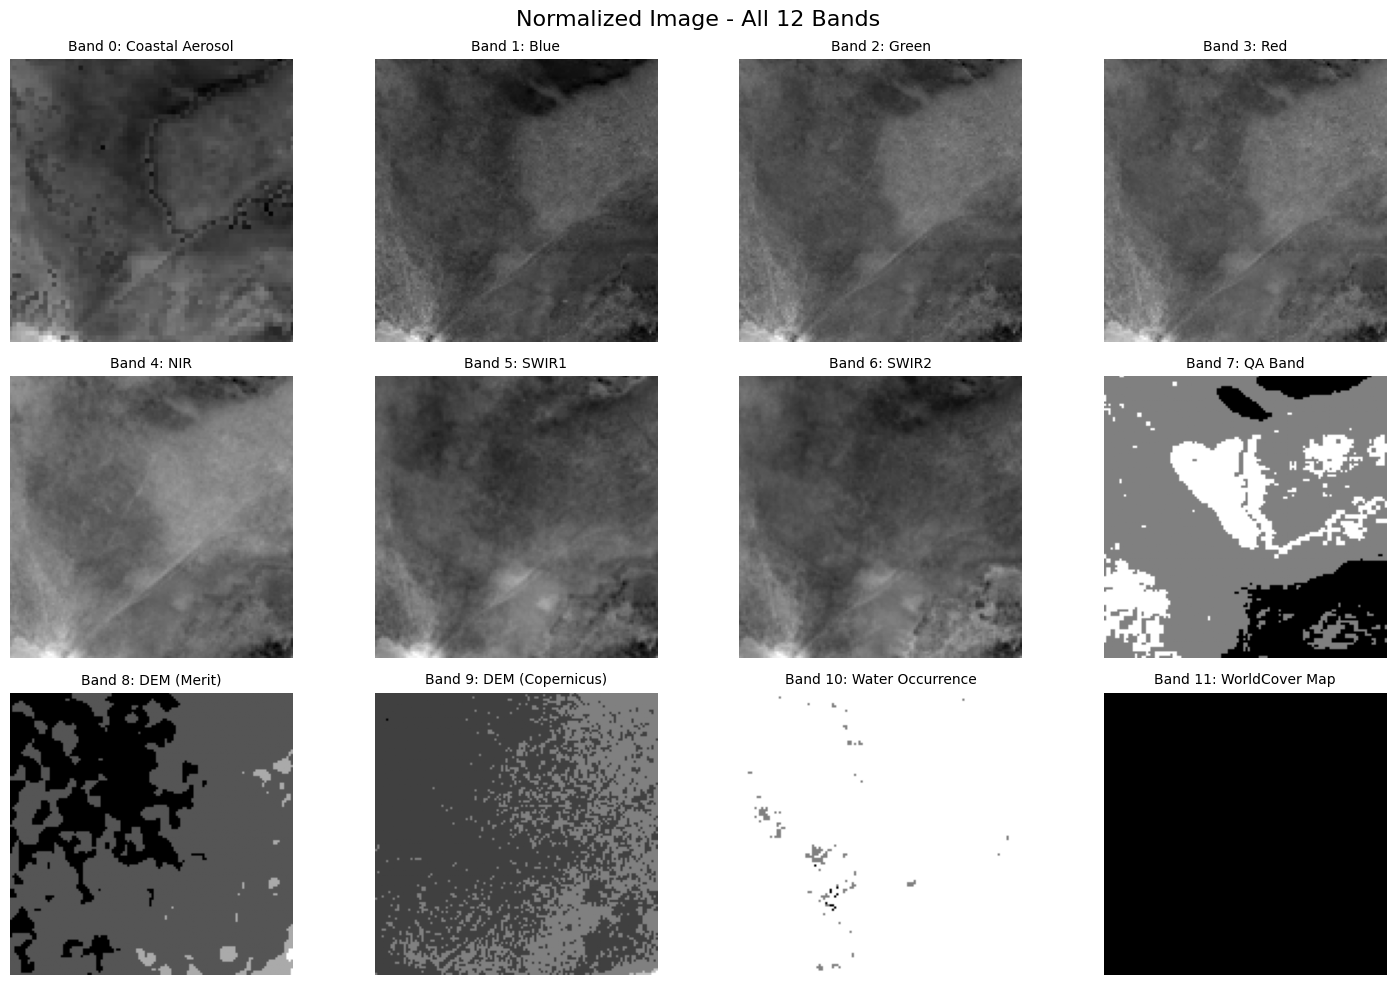

In [ ]:
import matplotlib.pyplot as plt

band_names = [
    "Coastal Aerosol",  # Band 0
    "Blue",             # Band 1
    "Green",            # Band 2
    "Red",              # Band 3
    "NIR",              # Band 4
    "SWIR1",            # Band 5
    "SWIR2",            # Band 6
    "QA Band",          # Band 7 (Quality mask)
    "DEM (Merit)",      # Band 8
    "DEM (Copernicus)", # Band 9
    "Water Occurrence", # Band 10
    "WorldCover Map"    # Band 11
]

image_to_display = x[100]

fig, axs = plt.subplots(3, 4, figsize=(15, 10))
axs = axs.flatten()

for i in range(12):
    axs[i].imshow(image_to_display[:, :, i], cmap='gray')
    axs[i].set_title(f'Band {i}: {band_names[i]}', fontsize=10)
    axs[i].axis('off')

plt.suptitle("Normalized Image - All 12 Bands", fontsize=16)
plt.tight_layout()
plt.show()


# Model Architecture and Training

In [16]:
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.10, random_state=44)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.222, random_state=44)

def to_loader(x, y, batch_size=2, shuffle=False, drop_last=False):
    x_tensor = torch.tensor(np.transpose(x, (0, 3, 1, 2)), dtype=torch.float32)
    y_tensor = torch.tensor(np.transpose(y, (0, 3, 1, 2)), dtype=torch.float32)
    dataset = TensorDataset(x_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)

train_loader = to_loader(x_train, y_train, batch_size=4, shuffle=True, drop_last=True) # Added drop_last=True
val_loader   = to_loader(x_val, y_val, batch_size=2) # Changed batch_size to 2
test_loader  = to_loader(x_test, y_test, batch_size=2) # Changed batch_size to 2

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (213, 128, 128, 12)
y_train shape: (213, 128, 128, 1)
x_val shape: (62, 128, 128, 12)
y_val shape: (62, 128, 128, 1)
x_test shape: (31, 128, 128, 12)
y_test shape: (31, 128, 128, 1)


In [26]:
def compute_iou(preds, masks, threshold=0.5, eps=1e-6):
    preds = (preds > threshold).float()
    masks = masks.float()

    intersection = (preds * masks).sum(dim=(1, 2, 3))
    union = ((preds + masks) > 0).float().sum(dim=(1, 2, 3))
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()


In [35]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.DeepLabV3Plus(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=12,
    classes=1,
    decoder_dropout=0.5
).to(device)

loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


for epoch in range(30):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        preds = model(images)
        loss = loss_fn(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            loss = loss_fn(preds, masks)
            val_loss += loss.item()

            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()

            all_preds.append(preds.cpu().numpy())
            all_masks.append(masks.cpu().numpy())

    y_pred_np = np.concatenate(all_preds, axis=0).astype(np.uint8).flatten()
    y_true_np = np.concatenate(all_masks, axis=0).astype(np.uint8).flatten()
    val_jaccard = jaccard_score(y_true_np, y_pred_np)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss / len(train_loader):.4f} | Val Loss: {val_loss / len(val_loader):.4f} | Val Jaccard IoU: {val_jaccard:.4f}")


Epoch 1 | Train Loss: 0.4974 | Val Loss: 0.5362 | Val Jaccard IoU: 0.4841
Epoch 2 | Train Loss: 0.4067 | Val Loss: 0.4888 | Val Jaccard IoU: 0.5173
Epoch 3 | Train Loss: 0.3310 | Val Loss: 0.4471 | Val Jaccard IoU: 0.5790
Epoch 4 | Train Loss: 0.3358 | Val Loss: 0.4405 | Val Jaccard IoU: 0.5983
Epoch 5 | Train Loss: 0.3081 | Val Loss: 0.4336 | Val Jaccard IoU: 0.6045
Epoch 6 | Train Loss: 0.2931 | Val Loss: 0.3627 | Val Jaccard IoU: 0.6717
Epoch 7 | Train Loss: 0.2862 | Val Loss: 0.3479 | Val Jaccard IoU: 0.6696
Epoch 8 | Train Loss: 0.2634 | Val Loss: 0.3401 | Val Jaccard IoU: 0.6780
Epoch 9 | Train Loss: 0.2736 | Val Loss: 0.3773 | Val Jaccard IoU: 0.6236
Epoch 10 | Train Loss: 0.2471 | Val Loss: 0.3513 | Val Jaccard IoU: 0.6666
Epoch 11 | Train Loss: 0.2232 | Val Loss: 0.3817 | Val Jaccard IoU: 0.6440
Epoch 12 | Train Loss: 0.2131 | Val Loss: 0.3617 | Val Jaccard IoU: 0.6618
Epoch 13 | Train Loss: 0.2228 | Val Loss: 0.3391 | Val Jaccard IoU: 0.6791
Epoch 14 | Train Loss: 0.1820 | Va

# Evaluation

In [36]:
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score

# Collect all test predictions and true masks
all_preds = []
all_masks = []

model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        preds = model(images)
        preds = preds.sigmoid().cpu().numpy()  # Apply sigmoid and move to CPU
        masks = masks.cpu().numpy()

        all_preds.append(preds)
        all_masks.append(masks)

# Concatenate all batches
all_preds = np.concatenate(all_preds, axis=0)  # Shape: (N, 1, H, W)
all_masks = np.concatenate(all_masks, axis=0)

# Threshold the predictions
all_preds_bin = (all_preds > 0.5).astype('uint8')
all_masks_bin = all_masks.astype('uint8')

# Flatten
y_true_flat = all_masks_bin.flatten()
y_pred_flat = all_preds_bin.flatten()

# Calculate and print metrics
print("IoU (Jaccard):", jaccard_score(y_true_flat, y_pred_flat))
print("Precision:", precision_score(y_true_flat, y_pred_flat))
print("Recall:", recall_score(y_true_flat, y_pred_flat))
print("F1-score:", f1_score(y_true_flat, y_pred_flat))


IoU (Jaccard): 0.799519971017118
Precision: 0.9578866270237424
Recall: 0.8286475983065644
F1-score: 0.8885924956589576
